# Tests de performance application IPS-rest et IPS-graphql

## Préparation : génération de la topologie et fonctions de génération d'intents

Fonctions de création de la topologie avec les APIs Rest et GraphQL :

In [104]:
import requests
from requests.auth import HTTPBasicAuth
import networkx as nx
import matplotlib.pyplot as plt
import time
import itertools
import random
import numpy as np

ip = "127.0.0.1"

def create_graph_graphql(ip):
    global gq_req_size
    # initialisation du graphe
    gr = nx.DiGraph()

    # requêtes au contrôleur ONOS
    url = "http://"+ip+":5000/graphql"
    liens_query = {'query': "query{liens{src,dst}}"}
    host_query = {'query': "query{hosts{id,locations}}"}
    r_hosts = requests.post(url, data = host_query)
    r_links = requests.post(url, data = liens_query)
    gq_req_size = len(r_hosts.content + r_links.content)

    if (r_hosts.status_code != 200):
        return "Erreur sur la liste des hôtes."
    elif (r_links.status_code != 200):
        return "Erreur sur la liste des liens."
    else:
        global host_list_mac_gq
        host_list_mac_gq = []
        host_list = r_hosts.json()['data']['hosts']
        link_list = r_links.json()['data']['liens']
        
        for l in link_list:
            l['src'] = eval(l['src'])
            l['dst'] = eval(l['dst'])
            gr.add_edge(l['src']['device'],l['dst']['device'],orig=l['src']['port'],dest=l['dst']['port'])
            gr.add_edge(l['dst']['device'],l['src']['device'],orig=l['dst']['port'],dest=l['src']['port'])
        
        for h in host_list:
            h['locations'] = list(eval(h['locations']))
            gr.add_node(h['id'],id=h['id'])
            host_list_mac_gq.append(h['id'])
            gr.add_edge(h['id'],h['locations'][0]["elementId"],orig="host",dest=h['locations'][0]["port"])
            gr.add_edge(h['locations'][0]["elementId"],h['id'],orig=h['locations'][0]["port"],dest="host")
        
        return gr
    
def create_graph_rest(ip):
    global rest_req_size
    # initialisation du graphe
    gr = nx.DiGraph()

    # requêtes au contrôleur ONOS
    r_host = requests.get("http://"+ip+":5000/rest/hosts")
    r_link = requests.get("http://"+ip+":5000/rest/links")
    rest_req_size = len(r_host.content + r_link.content)
    if (r_host.status_code != 200):
        return "Erreur sur la liste des hôtes."
    elif (r_link.status_code != 200):
        return "Erreur sur la liste des liens."
    else:
        global host_list_mac_re
        host_list_mac_re = []
        host_list = r_host.json()
        link_list = r_link.json()
        
        for l in link_list:
            gr.add_edge(l['src']['device'],l['dst']['device'],orig=l['src']['port'],dest=l['dst']['port'])
            gr.add_edge(l['dst']['device'],l['src']['device'],orig=l['dst']['port'],dest=l['src']['port'])
        
        for h in host_list:
            gr.add_node(h['id'],id=h['id'])
            host_list_mac_re.append(h['id'])
            gr.add_edge(h['id'],h['locations'][0]["elementId"],orig="host",dest=h['locations'][0]["port"])
            gr.add_edge(h['locations'][0]["elementId"],h['id'],orig=h['locations'][0]["port"],dest="host")
        
        return gr

Fonctions de génération d'intents

In [96]:
def install_intent_re(gr_rest,mac_o,mac_d,liste_chemin,count):
    global size_send_re,size_rece_re

    l=liste_chemin
    fwd_orig = ("","")
    fwd_dest = ("","")
    mac_orig = mac_o.replace("/None","")
    mac_dest = mac_d.replace("/None","")
    for i in range(0,len(l)-1):
        if i==len(l)-2:
            port = gr_rest.get_edge_data(l[i],l[i+1])
            fwd_dest = (l[i],port["orig"])
            intent_orig = fwd_orig[0]+"-"+fwd_orig[1]
            intent_dest = fwd_dest[0]+"-"+fwd_dest[1]
            
            r_intent = requests.get("http://"+ip+":5000/rest/intent?orig="+intent_orig+"&dest="+intent_dest
            +"&macorig="+mac_orig+"&macdest="+mac_dest)
            r_intent_inv = requests.get("http://"+ip+":5000/rest/intent?orig="+intent_dest+"&dest="+intent_orig
            +"&macorig="+mac_dest+"&macdest="+mac_orig)
            # size_send_re += int(r_intent.headers['Content-Length']) + int(r_intent_inv.headers['Content-Length'])
            # size_rece_re += len(r_intent.content + r_intent_inv.content)

            count += 2
        else:
            port = gr_rest.get_edge_data(l[i],l[i+1])
            if (port["orig"]=="host"):
                fwd_orig = (l[i+1],port["dest"])
            else:
                fwd_dest = (l[i],port["orig"])
                if (port["orig"]!="host"):
                    intent_orig = fwd_orig[0]+"-"+fwd_orig[1]
                    intent_dest = fwd_dest[0]+"-"+fwd_dest[1]
                    
                    r_intent = requests.get("http://"+ip+":5000/rest/intent?orig="+intent_orig+"&dest="+intent_dest
                    +"&macorig="+mac_orig+"&macdest="+mac_dest)
                    r_intent_inv = requests.get("http://"+ip+":5000/rest/intent?orig="+intent_dest+"&dest="+intent_orig
                    +"&macorig="+mac_dest+"&macdest="+mac_orig)
                    # size_send_re += int(r_intent.headers['Content-Length']) + int(r_intent_inv.headers['Content-Length'])
                    # size_rece_re += len(r_intent.content + r_intent_inv.content)
                    count += 2

                    fwd_orig = (l[i+1],port["dest"])
                else:
                    fwd_orig = ("","")
    return count

# def install_intent_gq2(gr_graphql,mac_o,mac_d,liste_chemin,count):
#     global size_send_gq,size_rece_gq

#     l=liste_chemin
#     fwd_orig = ("","")
#     fwd_dest = ("","")
#     mac_orig = mac_o.replace("/None","")
#     mac_dest = mac_d.replace("/None","")
#     string_mut="mutation MyMutation { \n"
    
#     for i in range(0,len(l)-1):
#         if i==len(l)-2:
#             port = gr_graphql.get_edge_data(l[i],l[i+1])
#             fwd_dest = (l[i],port["orig"])
#             intent_orig = fwd_orig[0]+"/"+fwd_orig[1]
#             intent_dest = fwd_dest[0]+"/"+fwd_dest[1]
#             string_mut += "r"+str(i)+": addIntent(intent_orig: \""+intent_orig+"\", mac_orig: \""+mac_orig+"\", intent_dest: \""+intent_dest+"\", mac_dest: \""+mac_dest+"\") { intent_orig, intent_dest }\n"
#             string_mut += "s"+str(i)+": addIntent(intent_orig: \""+intent_dest+"\", mac_orig: \""+mac_dest+"\", intent_dest: \""+intent_orig+"\", mac_dest: \""+mac_orig+"\") { intent_orig, intent_dest }\n"
#         else:
#             port = gr_graphql.get_edge_data(l[i],l[i+1])
#             if (port["orig"]=="host"):
#                 fwd_orig = (l[i+1],port["dest"])
#             else:
#                 fwd_dest = (l[i],port["orig"])
#                 if (port["orig"]!="host"):
#                     intent_orig = fwd_orig[0]+"/"+fwd_orig[1]
#                     intent_dest = fwd_dest[0]+"/"+fwd_dest[1]

#                     string_mut += "r"+str(i)+": addIntent(intent_orig: \""+intent_orig+"\", mac_orig: \""+mac_orig+"\", intent_dest: \""+intent_dest+"\", mac_dest: \""+mac_dest+"\") { intent_orig, intent_dest }\n"
#                     string_mut += "s"+str(i)+": addIntent(intent_orig: \""+intent_dest+"\", mac_orig: \""+mac_dest+"\", intent_dest: \""+intent_orig+"\", mac_dest: \""+mac_orig+"\") { intent_orig, intent_dest }\n"

#                     fwd_orig = (l[i+1],port["dest"])
#                 else:
#                     fwd_orig = ("","")

#     string_mut += "}"
#     mutation_query = {'query': string_mut}
#     query_gql = requests.post("http://"+ip+":5000/graphql", data = mutation_query)
#     # size_send_gq += int(query_gql.headers['Content-Length'])
#     # size_rece_gq += len(query_gql.content)
#     return count+1

# def install_intent_gq2(gr_graphql,mac_o,mac_d,liste_chemin,count):
#     global size_send_gq,size_rece_gq

#     l=liste_chemin
#     fwd_orig = ("","")
#     fwd_dest = ("","")
#     mac_orig = mac_o.replace("/None","")
#     mac_dest = mac_d.replace("/None","")
#     string_mut="mutation { addIntent(input: "
#     liste_intents = []
    
#     for i in range(0,len(l)-1):
#         if i==len(l)-2:
#             port = gr_graphql.get_edge_data(l[i],l[i+1])
#             fwd_dest = (l[i],port["orig"])
#             intent_orig = fwd_orig[0]+"/"+fwd_orig[1]
#             intent_dest = fwd_dest[0]+"/"+fwd_dest[1]
#             liste_intents.append("{intent_orig: \""+intent_orig+"\", mac_orig: \""+mac_orig+"\", intent_dest: \""+intent_dest+"\", mac_dest: \""+mac_dest+"\"}")
#             liste_intents.append("{intent_orig: \""+intent_dest+"\", mac_orig: \""+mac_dest+"\", intent_dest: \""+intent_orig+"\", mac_dest: \""+mac_orig+"\"}")
#         else:
#             port = gr_graphql.get_edge_data(l[i],l[i+1])
#             if (port["orig"]=="host"):
#                 fwd_orig = (l[i+1],port["dest"])
#             else:
#                 fwd_dest = (l[i],port["orig"])
#                 if (port["orig"]!="host"):
#                     intent_orig = fwd_orig[0]+"/"+fwd_orig[1]
#                     intent_dest = fwd_dest[0]+"/"+fwd_dest[1]

#                     liste_intents.append("{intent_orig: \""+intent_orig+"\", mac_orig: \""+mac_orig+"\", intent_dest: \""+intent_dest+"\", mac_dest: \""+mac_dest+"\"}")
#                     liste_intents.append("{intent_orig: \""+intent_dest+"\", mac_orig: \""+mac_dest+"\", intent_dest: \""+intent_orig+"\", mac_dest: \""+mac_orig+"\"}")

#                     fwd_orig = (l[i+1],port["dest"])
#                 else:
#                     fwd_orig = ("","")

#     string_mut += "["+",".join(liste_intents)+"]) { intent_orig, intent_dest } }"
    
#     mutation_query = {'query': string_mut}
#     # print(mutation_query)
#     query_gql = requests.post("http://"+ip+":5000/graphql", data = mutation_query)
#     # print(query_gql.content)
#     # size_send_gq += int(query_gql.headers['Content-Length'])
#     # size_rece_gq += len(query_gql.content)
#     return count

def install_intent_gq(gr_graphql,mac_o,mac_d,liste_chemin):
    l=liste_chemin
    fwd_orig = ("","")
    fwd_dest = ("","")
    mac_orig = mac_o.replace("/None","")
    mac_dest = mac_d.replace("/None","")
    # string_mut="mutation { addIntent2(input: "
    liste_intents = []
    
    for i in range(0,len(l)-1):
        if i==len(l)-2:
            port = gr_graphql.get_edge_data(l[i],l[i+1])
            fwd_dest = (l[i],port["orig"])
            intent_orig = fwd_orig[0]+"/"+fwd_orig[1]
            intent_dest = fwd_dest[0]+"/"+fwd_dest[1]
            liste_intents.append("{intentOrig: \""+intent_orig+"\", macOrig: \""+mac_orig+"\", intentDest: \""+intent_dest+"\", macDest: \""+mac_dest+"\"}")
            liste_intents.append("{intentOrig: \""+intent_dest+"\", macOrig: \""+mac_dest+"\", intentDest: \""+intent_orig+"\", macDest: \""+mac_orig+"\"}")
        else:
            port = gr_graphql.get_edge_data(l[i],l[i+1])
            if (port["orig"]=="host"):
                fwd_orig = (l[i+1],port["dest"])
            else:
                fwd_dest = (l[i],port["orig"])
                if (port["orig"]!="host"):
                    intent_orig = fwd_orig[0]+"/"+fwd_orig[1]
                    intent_dest = fwd_dest[0]+"/"+fwd_dest[1]

                    liste_intents.append("{intentOrig: \""+intent_orig+"\", macOrig: \""+mac_orig+"\", intentDest: \""+intent_dest+"\", macDest: \""+mac_dest+"\"}")
                    liste_intents.append("{intentOrig: \""+intent_dest+"\", macOrig: \""+mac_dest+"\", intentDest: \""+intent_orig+"\", macDest: \""+mac_orig+"\"}")

                    fwd_orig = (l[i+1],port["dest"])
                else:
                    fwd_orig = ("","")
    return liste_intents

def liste_couples_res():
    liste_couples = list(itertools.combinations(host_list_mac_re, 2))
    liste_res = []

    global ent
    ent = np.floor(len(liste_couples)/10).astype(int)
    for i in range(1,11):
        liste_res.append(random.choices(liste_couples, k=ent*i))
    return liste_res

def do_install_intent(gr_rest,gr_graphql):
    global size_send_gq,size_rece_gq

    temps_re = []
    temps_gq = []

    count_re = []
    count_gq = []

    liste_couples = liste_couples_res()

    for i in liste_couples:
        count = 0
        start = time.time()
        for elt in i:
            # clean = requests.get("http://"+ip+":5000/removeIntents")
            count = install_intent_re(gr_rest,elt[0],elt[1],nx.shortest_path(gr_rest,elt[0],elt[1]),count)
        end = time.time()
        temps_re.append(round(end-start,1))
        count_re.append(count)

    for i in liste_couples:
        res = []
        for elt in i:
            res.append(install_intent_gq(gr_graphql,elt[0],elt[1],nx.shortest_path(gr_graphql,elt[0],elt[1])))
        
        flatten = itertools.chain.from_iterable
        res = list(flatten(res))

        string_mut ="mutation MyMutation { addIntent(intentList: "
        string_mut += "["+",".join(res)+"]) { ok } }"

        mutation_query = {'query': string_mut}
        # print(mutation_query)
        start = time.time()
        query_gql = requests.post("http://"+ip+":5000/graphql", data = mutation_query)
        print(query_gql.content)
        end = time.time()
        # size_send_gq += int(query_gql.headers['Content-Length'])
        # size_rece_gq += len(query_gql.content)
        temps_gq.append(round(end-start,1))
        count_gq.append(count)

    return [temps_re,temps_gq,count_re,count_gq]

def trace_resultats(l):
    pourc = []
    pourc2 = []
    for i in range(0,10):
        pourc.append((l[0][i]-l[1][i])*100/l[0][i])
        pourc2.append((l[2][i]-l[3][i])*100/l[2][i])
    print(pourc)
    print(np.mean(pourc))
    print(pourc2)
    print(np.mean(pourc2))

    labels = []
    for i in range(1,11):
        labels.append(str(ent*i))

    x = np.arange(len(labels))
    width = 0.42

    fig, ax = plt.subplots(figsize=(17,8))
    fig2, ax2 = plt.subplots(figsize=(17,8))

    rects1 = ax.bar(x - width/2, l[0], width, label='Rest')
    rects2 = ax.bar(x + width/2, l[1], width, label='GraphQL')

    rects3 = ax2.bar(x, l[2], width, label='Rest')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Nombre de couples générés')
    ax.set_ylabel('Temps en secondes')
    ax.set_title('Temps de génération des intents')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    ax.bar_label(rects1)
    ax.bar_label(rects2)

    fig.tight_layout()

    ax2.set_xlabel('Nombre de couples générés')
    ax2.set_ylabel('Nombre de requêtes')
    ax2.set_title('Nombre de requêtes nécessaires à la génération des intents')
    ax2.set_xticks(x)
    ax2.set_xticklabels(labels)
    ax2.legend()

    ax2.bar_label(rects3)

    fig2.tight_layout()

    plt.rcParams["font.size"] = "20"
    plt.show()

## Tests : méthode

- on compte le nombre d'hôtes N de la topologie : le nombre de paires d'hôtes à relier au total est alors T = N*(N-1)/2
- on calcule une liste L de 10 nombres Ti régulièrement espacés de paires d'hôtes à relier, qui seront choisis au hasard parmi la liste de toutes les paires d'hôtes de la topologie
- pour chaque liste de paires d'hôtes à relier, on installe les intents nécessaires pour router correctement tous les paquets entre chaque paire d'hôte

### T1 : topologie torus,3,3 : 9 hôtes, 36 liens

In [98]:
gq_req_size = 0
rest_req_size = 0
size_send_re = 0
size_rece_re = 0
size_send_gq = 0
size_rece_gq = 0

gr_rest = create_graph_rest(ip)
gr_graphql = create_graph_graphql(ip)

l = do_install_intent(gr_rest,gr_graphql)
print(l)

b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
b'{"data":{"addIntent":{"ok":true}}}'
[[0.2, 0.6, 0.7, 0.9, 1.1, 1.5, 2.2, 2.6, 2.8, 3.2], [0.1, 0.4, 0.4, 0.8, 0.8, 0.9, 1.2, 2.9, 2.6, 2.3], [14, 30, 44, 60, 78, 92, 102, 124, 132, 148], [148, 148, 148, 148, 148, 148, 148, 148, 148, 148]]


[50.0, 33.33333333333333, 42.85714285714285, 11.111111111111109, 27.272727272727273, 40.0, 45.45454545454546, -11.538461538461531, 7.1428571428571335, 28.125000000000007]
27.375825563325566
[-957.1428571428571, -393.3333333333333, -236.36363636363637, -146.66666666666666, -89.74358974358974, -60.869565217391305, -45.09803921568628, -19.35483870967742, -12.121212121212121, 0.0]
-196.069373851405


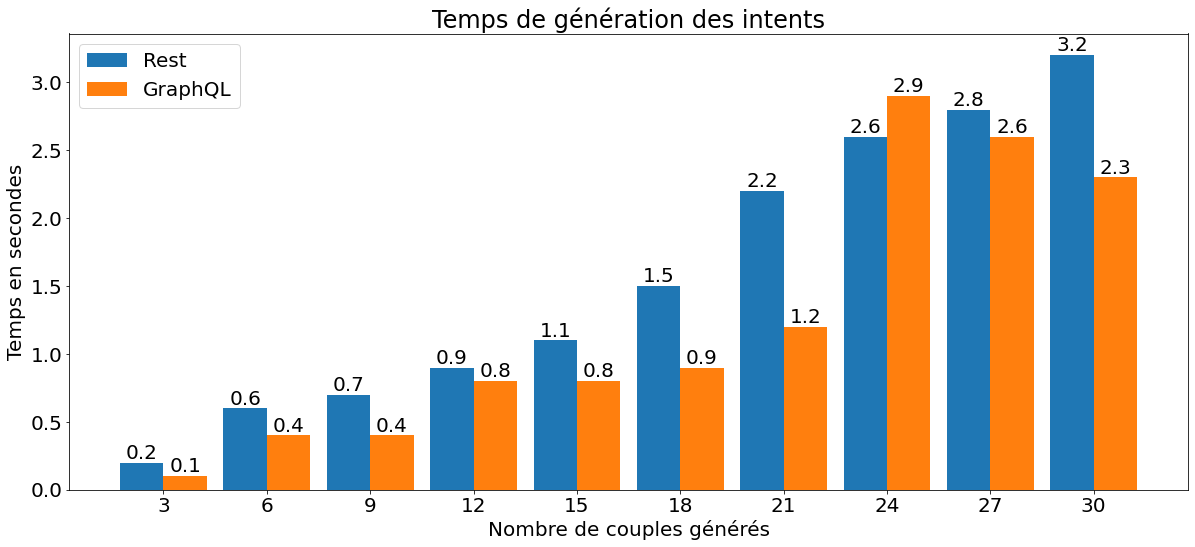

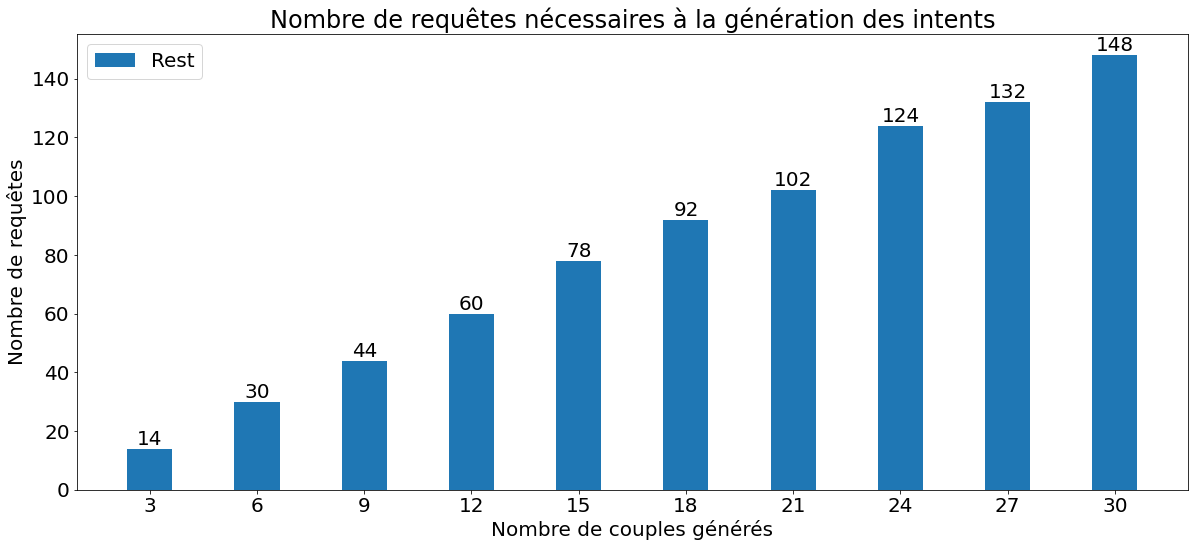

In [99]:
trace_resultats(l)

### T2 : topologie torus,4,4 : 16 hôtes, 64 liens

In [105]:
gq_req_size = 0
rest_req_size = 0
size_send_re = 0
size_rece_re = 0
size_send_gq = 0
size_rece_gq = 0

gr_rest = create_graph_rest(ip)
gr_graphql = create_graph_graphql(ip)

l2 = do_install_intent(gr_rest,gr_graphql)
print(l2)

ConnectionError: HTTPConnectionPool(host='192.168.56.101', port=5000): Max retries exceeded with url: /rest/hosts (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000019A51743250>: Failed to establish a new connection: [WinError 10061] Aucune connexion n’a pu être établie car l’ordinateur cible l’a expressément refusée'))

[0.0, -4.1666666666666705, 0.0, 7.27272727272728, 1.5151515151515098, 3.5714285714285796, 1.17647058823529, 4.8076923076923075, 5.426356589147296, 3.787878787878788]
2.339103896559438
[81.25, 80.0, 80.43478260869566, 80.64516129032258, 80.76923076923077, 81.25, 79.0, 79.3103448275862, 80.71428571428571, 80.51948051948052]
80.38932857296014


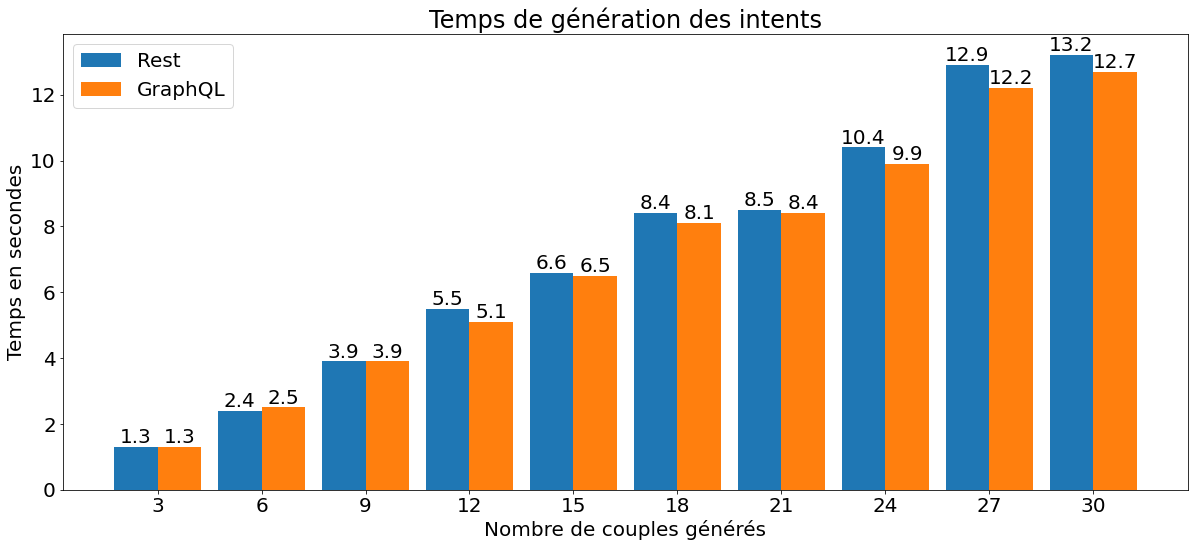

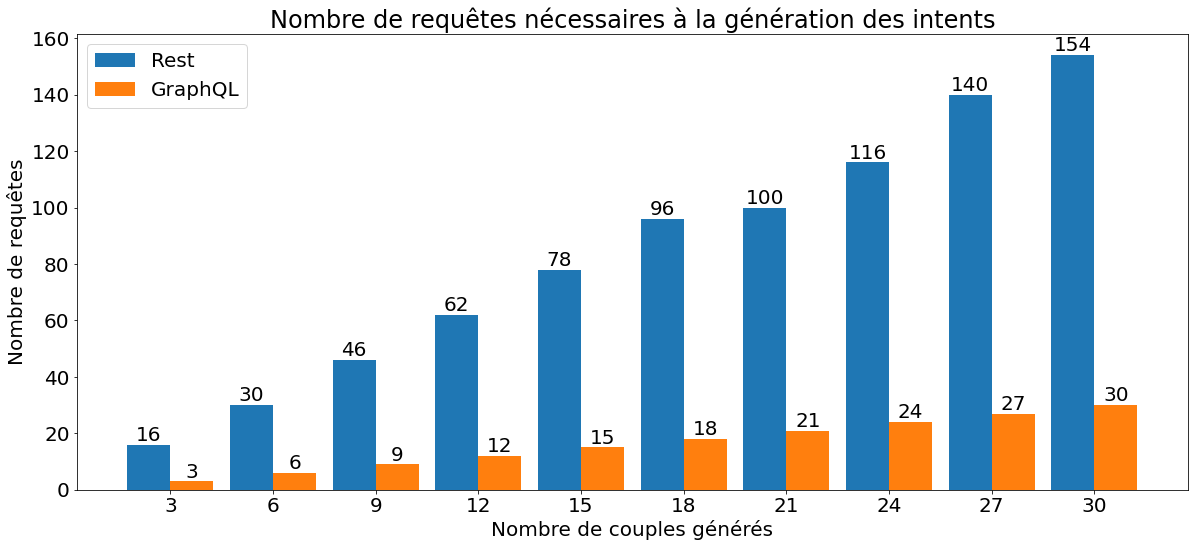

In [9]:
trace_resultats(l2)